In [1]:
#Get libraries
#from pandas import DataFrame as df #dataframe library
import pandas as pd 
import numpy as np

!pip install geocoder
import json # library to handle JSON files
!pip install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins
from folium.plugins import MarkerCluster

print("All list!")


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --yes
All list!


#Foursquare credentials


In [2]:
#Define Foursquare Credentials and Version

CLIENT_ID = 'HPTTXE151PAZP3JOZ4JXGC5KK3ABHC4K3TBDFXS0XCHFH5VW' # your Foursquare ID
CLIENT_SECRET = 'V4QC5NTCQJTKAVG2QRJ2ZQLQ4X2XLPJLC22GKWGRXJCBFEK5' # your Foursquare Secret
ACCESS_TOKEN = 'IEWOSBSL540XFMIVAIBD3MYC1S0HNRVNGFU0NQ5X3WMIPMLB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HPTTXE151PAZP3JOZ4JXGC5KK3ABHC4K3TBDFXS0XCHFH5VW
CLIENT_SECRET:V4QC5NTCQJTKAVG2QRJ2ZQLQ4X2XLPJLC22GKWGRXJCBFEK5


#Get municipalities table

In [3]:
url = 'https://es.wikipedia.org/wiki/Demarcaciones_territoriales_de_la_Ciudad_de_M%C3%A9xico' #Get URL
table = pd.read_html(url) #Read html
df = table[1] #get dataframe
#clean dataframe
df.drop([0,1], axis=0,inplace=True)
df.drop([0],axis=1,inplace=True)
df.columns=  df.iloc[0]
df.drop([2],axis=0,inplace=True)
df.reset_index(inplace=True, drop=True)
df.rename(columns={"Alcaldías":"borough","Población (2016)":"population",
                   "Densidad de habitantes (km²)":"density",
                   "Código postal":"postal code", "Superficie (km²)":"area"}, inplace=True)
df.dropna(inplace=True)
df.rename_axis(None,axis=1).rename_axis(" ",axis=0)
#Sort dataframe 
df.sort_values(by="borough",inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(16, 5)


2,borough,population,area,density,postal code
0,Azcapotzalco,414711,33.66,12.635,02000 - 02999
1,Benito Juárez,385439,26.63,13.331,03000 - 03999
2,Coyoacán,620416,54.4,11.545,04000 - 04999
3,Cuajimalpa de Morelos,186391,74.58,2.328,05000 - 05999
4,Cuauhtémoc,531831,32.4,16.071,06000 - 06999


#Get municipalities coordinates

In [4]:
url2 = "https://datos.cdmx.gob.mx/explore/dataset/alcaldias/download/?format=csv&timezone=America/Mexico_City&lang=es&use_labels_for_header=true&csv_separator=%2C"
table2 = pd.read_csv(url2) #Read html
df2 = table2
df2.drop(["CLAVE_MUNICIPAL","CVE_ENTIDAD","CVEGEO","Geo Shape","municipio"], axis=1, inplace=True)
df2 = pd.concat([df2["NOMBRE"], df2["Geo Point"].str.split(',', expand=True)], axis=1)
df2.rename(columns={"NOMBRE":"borough2",0:"Latitude",1:"Longitude"},inplace=True)
df2.sort_values(by="borough2",inplace= True)
df2.reset_index(inplace=True, drop=True)
print(df2.shape)
df2.head()

(16, 3)


,borough2,Latitude,Longitude
0,Azcapotzalco,19.4853286147,-99.1821069423
1,Benito Juárez,19.3806424162,-99.1611346584
2,Coyoacán,19.3266672536,-99.1503763525
3,Cuajimalpa de Morelos,19.3246343001,-99.3107285253
4,Cuauhtémoc,19.4313734294,-99.1490557562


#Concat both dataframes

In [5]:
df_cdmx = pd.concat([df,df2], axis=1)
df_cdmx.drop("borough2",axis=1,inplace=True)
df_cdmx["Latitude"] = df_cdmx["Latitude"].astype(float)
df_cdmx["Longitude"] = df_cdmx["Longitude"].astype(float)
df_cdmx.round({"Latitude":7,"Longitude":7}) #round because geocoder accepts only 7 decimals coordinates

df_cdmx.head()


,borough,population,area,density,postal code,Latitude,Longitude
0,Azcapotzalco,414711,33.66,12.635,02000 - 02999,19.485329,-99.182107
1,Benito Juárez,385439,26.63,13.331,03000 - 03999,19.380642,-99.161135
2,Coyoacán,620416,54.4,11.545,04000 - 04999,19.326667,-99.150376
3,Cuajimalpa de Morelos,186391,74.58,2.328,05000 - 05999,19.324634,-99.310729
4,Cuauhtémoc,531831,32.4,16.071,06000 - 06999,19.431373,-99.149056


#Map of Mexico City

In [6]:
#Get coordinates of Mexico City

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode('CDMX, Mexico')
cdmx_latitude = location.latitude
cdmx_longitude = location.longitude
print('The geograpical coordinate of Mexico City are {}, {}.'.format(cdmx_latitude, cdmx_longitude))


The geograpical coordinate of Mexico City are 19.4326296, -99.1331785.


In [7]:
#Mexico City's map with all municipalities

cdmx_map = folium.Map(location=[cdmx_latitude, cdmx_longitude], zoom_start=11)

for dist, lat, lng in zip(df_cdmx['borough'], df_cdmx['Latitude'], df_cdmx['Longitude']):
    label = folium.Popup(dist, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cdmx_map)  
    
cdmx_map

#Get venues in Mexico City

In [8]:
#function to get nearby venues in Mexico City

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
#create a new dataframe called cdmx_venues
cdmx_venues = getNearbyVenues(names=df_cdmx['borough'],
                                   latitudes=df_cdmx['Latitude'],
                                   longitudes=df_cdmx['Longitude']
                                  )

Azcapotzalco
Benito Juárez
Coyoacán
Cuajimalpa de Morelos
Cuauhtémoc
Gustavo A. Madero
Iztacalco
Iztapalapa
Magdalena Contreras
Miguel Hidalgo
Milpa Alta
Tlalpan
Tláhuac
Venustiano Carranza
Xochimilco
Álvaro Obregón


In [10]:
#See dataframe
print(cdmx_venues.shape)
cdmx_venues.head()

(375, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Azcapotzalco,19.485329,-99.182107,Neko Café,19.484152,-99.183326,Japanese Restaurant
1,Azcapotzalco,19.485329,-99.182107,Café Revolución,19.484433,-99.183248,Breakfast Spot
2,Azcapotzalco,19.485329,-99.182107,Centro Verde Azcapotzalco,19.487757,-99.182125,Garden
3,Azcapotzalco,19.485329,-99.182107,Frody,19.482723,-99.182390,Ice Cream Shop
4,Azcapotzalco,19.485329,-99.182107,Café ONCE28,19.484427,-99.185720,Breakfast Spot


In [11]:
#check how many venues were returned for each municipality
cdmx_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Azcapotzalco,20,20,20,20,20,20
Benito Juárez,27,27,27,27,27,27
Coyoacán,28,28,28,28,28,28
Cuajimalpa de Morelos,1,1,1,1,1,1
Cuauhtémoc,98,98,98,98,98,98
Gustavo A. Madero,8,8,8,8,8,8
Iztacalco,22,22,22,22,22,22
Iztapalapa,26,26,26,26,26,26
Magdalena Contreras,1,1,1,1,1,1


In [12]:
# unique categories
print('There are {} uniques categories.'.format(len(cdmx_venues['Venue Category'].unique())))

There are 122 uniques categories.


#One hot encoding

In [13]:
# one hot encoding
cdmx_onehot = pd.get_dummies(cdmx_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cdmx_onehot['Neighborhood'] = cdmx_venues['Neighborhood'] 

# move neighbourhood column to the first column
fixed_columns = [cdmx_onehot.columns[-1]] + list(cdmx_onehot.columns[:-1])
cdmx_onehot = cdmx_onehot[fixed_columns]
print(#new dataframe size

cdmx_onehot.shape)
cdmx_onehot.head()

(375, 123)


,Neighborhood,Airport,Airport Service,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Garden,Bike Rental / Bike Share,Bistro,Bookstore,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Cafeteria,Café,Candy Store,Coffee Shop,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Cupcake Shop,Cycle Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,...,Office,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Pub,Public Art,Restaurant,Rock Club,Russian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Theme Park,Track,Trail,Vegetarian / Vegan Restaurant,Women's Store
0,Azcapotzalco,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Azcapotzalco,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Azcapotzalco,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Azcapotzalco,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Azcapotzalco,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

cdmx_grouped = cdmx_onehot.groupby('Neighborhood').mean().reset_index()
#confirm new size
print(cdmx_grouped.shape)
cdmx_grouped

(15, 123)


,Neighborhood,Airport,Airport Service,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Garden,Bike Rental / Bike Share,Bistro,Bookstore,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Cafeteria,Café,Candy Store,Coffee Shop,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Cupcake Shop,Cycle Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,...,Office,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Pub,Public Art,Restaurant,Rock Club,Russian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Theme Park,Track,Trail,Vegetarian / Vegan Restaurant,Women's Store
0,Azcapotzalco,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.100000,0.000000,0.000000,0.00,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Benito Juárez,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.037037,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.037037,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.037037,0.000000,0.000,0.037037,0.000000,0.148148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.037037,0.000,0.037037,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.037037,0.037037,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Coyoacán,0.00,0.00,0.000000,0.035714,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.035714,0.000000,0.000,0.000000,0.000000,0.035714,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.250000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000
3,Cuajimalpa de Morelos,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Cuauhtémoc,0.00,0.00,0.020408,0.030612,0.010204,0.020408,0.010204,0.000000,0.000000,0.030612,0.030612,0.00,0.010204,0.010204,0.010204,0.00

#Most common venues

In [15]:
#print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in cdmx_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = cdmx_grouped[cdmx_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Azcapotzalco----
                venue  freq
0  Mexican Restaurant  0.20
1      Ice Cream Shop  0.15
2          Taco Place  0.10
3      Breakfast Spot  0.10
4  Seafood Restaurant  0.10


----Benito Juárez----
                venue  freq
0         Pizza Place  0.15
1         Coffee Shop  0.07
2  Mexican Restaurant  0.07
3         IT Services  0.04
4         Supermarket  0.04


----Coyoacán----
                venue  freq
0          Taco Place  0.25
1  Seafood Restaurant  0.07
2      Ice Cream Shop  0.07
3          Steakhouse  0.04
4          Food Court  0.04


----Cuajimalpa de Morelos----
         venue  freq
0         Park   1.0
1      Airport   0.0
2         Pool   0.0
3  Pizza Place   0.0
4     Pharmacy   0.0


----Cuauhtémoc----
                venue  freq
0  Mexican Restaurant  0.14
1          Taco Place  0.06
2       Deli / Bodega  0.04
3               Hotel  0.04
4         Art Gallery  0.03


----Gustavo A. Madero----
                  venue  freq
0                  Park  0.

In [16]:
#function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
#create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cdmx_grouped['Neighborhood']

for ind in np.arange(cdmx_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cdmx_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Azcapotzalco,Mexican Restaurant,Ice Cream Shop,Taco Place,Seafood Restaurant,Breakfast Spot,Burrito Place,Bakery,Food Court,Japanese Restaurant,Garden
1,Benito Juárez,Pizza Place,Mexican Restaurant,Coffee Shop,Pet Store,Southern / Soul Food Restaurant,Greek Restaurant,IT Services,Ice Cream Shop,Dog Run,Deli / Bodega
2,Coyoacán,Taco Place,Seafood Restaurant,Ice Cream Shop,Gym / Fitness Center,Fast Food Restaurant,Park,Coffee Shop,Mexican Restaurant,Pizza Place,Pool
3,Cuajimalpa de Morelos,Park,Women's Store,Comfort Food Restaurant,Convenience Store,Cupcake Shop,Cycle Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner
4,Cuauhtémoc,Mexican Restaurant,Taco Place,Deli / Bodega,Hotel,Coffee Shop,Art Gallery,Bar,Restaurant,Café,Bakery


In [18]:
temp = cdmx_grouped.iloc[:,1:].sum().sort_values(ascending=False)
temp2 = temp.sum()
cdmx_lank = temp.head(10)/temp2
print('-----CDMX-----')
print(cdmx_lank)

-----CDMX-----
Mexican Restaurant    0.118361
Taco Place            0.095525
Park                  0.091291
Forest                0.066667
Electronics Store     0.034100
Bakery                0.029751
Pizza Place           0.026339
Seafood Restaurant    0.025338
Sushi Restaurant      0.024748
Ice Cream Shop        0.022094
dtype: float64


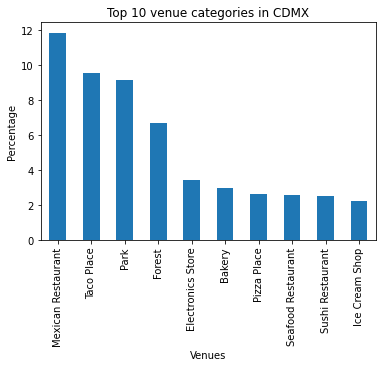

In [19]:
#Plot top 10 venues categories in CDMX

cdmx_lank = cdmx_lank*100
cdmx_lank.plot(kind='bar')
plt.title('Top 10 venue categories in CDMX')
plt.xlabel('Venues')
plt.ylabel('Percentage')
plt.show()

#Elbow method to find optimal k-value

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#Get equal scales
mms = MinMaxScaler()
mms.fit(cdmx_grouped.drop("Neighborhood",axis=1))
data_transformed = mms.transform(cdmx_grouped.drop("Neighborhood",axis=1))
data_transformed

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

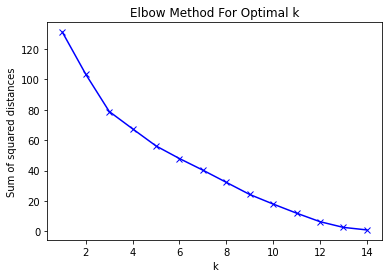

In [21]:
#Get squared distances and plot each k value

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#Cluster with kmeans

In [22]:
#Run kmeans to cluster the neighborhood into 5 clusters.

# set number of clusters
kclusters = 3

cdmx_grouped_clustering = cdmx_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cdmx_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 0, 0, 0, 0, 2, 0], dtype=int32)

In [23]:
#Merge dataframes
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
cdmx_merged = df_cdmx
cdmx_merged = cdmx_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood')
                                      , on='borough',how ='inner')

cdmx_merged.drop("postal code", axis=1, inplace=True)
cdmx_merged.head()

,borough,population,area,density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Azcapotzalco,414711,33.66,12.635,19.485329,-99.182107,0,Mexican Restaurant,Ice Cream Shop,Taco Place,Seafood Restaurant,Breakfast Spot,Burrito Place,Bakery,Food Court,Japanese Restaurant,Garden
1,Benito Juárez,385439,26.63,13.331,19.380642,-99.161135,0,Pizza Place,Mexican Restaurant,Coffee Shop,Pet Store,Southern / Soul Food Restaurant,Greek Restaurant,IT Services,Ice Cream Shop,Dog Run,Deli / Bodega
2,Coyoacán,620416,54.4,11.545,19.326667,-99.150376,0,Taco Place,Seafood Restaurant,Ice Cream Shop,Gym / Fitness Center,Fast Food Restaurant,Park,Coffee Shop,Mexican Restaurant,Pizza Place,Pool
3,Cuajimalpa de Morelos,186391,74.58,2.328,19.324634,-99.310729,1,Park,Women's Store,Comfort Food Restaurant,Convenience Store,Cupcake Shop,Cycle Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner
4,Cuauhtémoc,531831,32.4,16.071,19.431373,-99.149056,0,Mexican Restaurant,Taco Place,Deli / Bodega,Hotel,Coffee Shop,Art Gallery,Bar,Restaurant,Café,Bakery


In [24]:
#Visualize resulting clusters
# create map
map_clusters = folium.Map(location=[cdmx_latitude, cdmx_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cdmx_merged['Latitude'], cdmx_merged['Longitude'], 
                                  cdmx_merged['borough'], cdmx_merged['Cluster Labels']):
  
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [25]:
#Examine clusters:
#Cluster 1
cdmx_merged.loc[cdmx_merged['Cluster Labels'] == 0, 
                     cdmx_merged.columns[[1] + list(range(5, cdmx_merged.shape[1]))]]

,population,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,414711,-99.182107,0,Mexican Restaurant,Ice Cream Shop,Taco Place,Seafood Restaurant,Breakfast Spot,Burrito Place,Bakery,Food Court,Japanese Restaurant,Garden
1,385439,-99.161135,0,Pizza Place,Mexican Restaurant,Coffee Shop,Pet Store,Southern / Soul Food Restaurant,Greek Restaurant,IT Services,Ice Cream Shop,Dog Run,Deli / Bodega
2,620416,-99.150376,0,Taco Place,Seafood Restaurant,Ice Cream Shop,Gym / Fitness Center,Fast Food Restaurant,Park,Coffee Shop,Mexican Restaurant,Pizza Place,Pool
4,531831,-99.149056,0,Mexican Restaurant,Taco Place,Deli / Bodega,Hotel,Coffee Shop,Art Gallery,Bar,Restaurant,Café,Bakery
5,1185772,-99.115864,0,Performing Arts Venue,Hot Dog Joint,Fast Food Restaurant,Scenic Lookout,Athletics & Sports,Movie Theater,Park,Shopping Mall,Deli / Bodega,Cycle Studio
6,384326,-99.094330,0,Taco Place,Pizza Place,Salad Place,Sandwich Place,Sushi Restaurant,College Gym,Food Court,Fast Food Restaurant,Food Truck,BBQ Joint
7,1815786,-99.056799,0,Taco Place,Mexican Restaurant,Coffee Shop,Park,Café,Food Truck,Ice Cream Shop,Bakery,Farmers Market,Dog Run
9,372889,-99.204567,0,Mexican Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Seafood Restaurant,Mediterranean Restaurant,Park,Ice Cream Shop,Health & Beauty Service,Pizza Place
11,650567,-99.206221,0,Mexican Restaurant,Electronics Store,Women's Store,Comfort Food Restaurant,Convenience Store,Cupcake Shop,Cycle Studio,Deli / Bodega,Design Studio,Dessert Shop
12,360265,-99.002822,0,Convenience Store,Taco Place,Seafood Restaurant,Diner,Bar,Bakery,Mexican Restaurant,Athletics & Sports,Dessert Shop,Pizza Place


In [26]:
#Examine clusters:
#Cluster 1
cdmx_merged.loc[cdmx_merged['Cluster Labels'] == 1, 
                     cdmx_merged.columns[[1] + list(range(5, cdmx_merged.shape[1]))]]

,population,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,186391,-99.310729,1,Park,Women's Store,Comfort Food Restaurant,Convenience Store,Cupcake Shop,Cycle Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner


In [27]:
#Examine clusters:
#Cluster 3
cdmx_merged.loc[cdmx_merged['Cluster Labels'] == 2, 
                     cdmx_merged.columns[[1] + list(range(5, cdmx_merged.shape[1]))]]

,population,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,239086,-99.268413,2,Forest,Women's Store,Fast Food Restaurant,Convenience Store,Cupcake Shop,Cycle Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner
